In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
google_colab = input('Running on Colab?\n')
if google_colab=='yes' : 
    BASE_DIR = 'University/UC3M/TFM/cnp_repo/neural-processes'

    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    drive.mount('/content/drive')

      # Change to assignment directory ('Lab_Exercises_DASS/Lab_Exercise4' by default)
    import os
    os.chdir(f'/content/drive/My Drive/{BASE_DIR}')
    
else:
    import sys, os 
    BASE_DIR = '/'.join(os.getcwd().split('/')[:-1])
    sys.path.append(BASE_DIR)
    print(f'Top level directory is set to {BASE_DIR}')
    os.chdir(BASE_DIR)

    
# custom imports
from cnp.trainer import RegressionTrainer
from cnp.datageneration import DataGenerator
from cnp.helpers import Helper

import torch
import numpy as np
from torch import nn


# import utils
import json
from datetime import date

Running on Colab?

Top level directory is set to /Users/frederik/Google Drive/University/UC3M/TFM/cnp_repo/neural-processes


In [3]:

# we first get the variables for the configuration file
os.environ["CHECKPOINT_DIR"] = "checkpoints"
os.environ["MODEL_PARAMS"] = "default"

CHECKPOINT_DIR = os.environ['CHECKPOINT_DIR']
MODEL_PARAMS = os.environ['MODEL_PARAMS']

if google_colab=='yes':
    config_dir = ''
else:
    config_dir = os.path.join(BASE_DIR,'configs')

with open(os.path.join(config_dir,'1dpolynomial_fixedcontxt_mlpaggr.json')) as f:
    file = f.read()
    default_conf = json.loads(file)



In [4]:

# checking whether CUDA is available 
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
    default_conf['experiment_params']['train_on_gpu'] = True
else: 
    print('No GPU available, training on CPU')
    default_conf['experiment_params']['train_on_gpu'] = False

No GPU available, training on CPU


## We will first try to replicate what we have after one encoding step

In [5]:
import pandas as pd 
import numpy as np
import sys
import matplotlib.pyplot as plt
from cnp.networks import Encoder, create_linear_layer
from cnp.cnp import get_sample_indexes, select_data
from sklearn.linear_model import LinearRegression
from cnp.datageneration import PolynomialRegression

In [6]:
batch_size = 50

In [7]:
poly = PolynomialRegression()
data = poly.generate_curves(mu=0, sigma=2, num_instances_train=1,
                        num_instances_vali=None, num_instances_test=None,
                        purpose='train', seed=None)

In [8]:
data[1][0].shape

torch.Size([400, 1])

In [93]:
encoder = Encoder(insize=2, num_layers=3, num_neurons=128, dimout=128)

In [94]:
x = data[0][:10:]
y = data[1][0][:10,:]

In [97]:
encoding = encoder(x, y)[None, :, :]
encoding_large = encoding.repeat(64,1,1)
encoding_large.shape

torch.Size([64, 10, 128])

- When we are taking the mean we say that each context point is equally important 
- When we parametize this function we say that not each point is equally important

In [82]:
weights = torch.randn(1,1,10)
weights_large = weights.repeat(64,1,1)

In [83]:
encoding.shape

torch.Size([1, 10, 128])

In [65]:
torch.mm(weights[0], encoding[0]).sum()

tensor(26.9362, grad_fn=<SumBackward0>)

In [67]:
torch.bmm(weights_large, encoding_large)[1].sum()

tensor(26.9362, grad_fn=<SumBackward0>)

In [ ]:
encoding = torch.randn(64,)

In [45]:
torch.mm(weights,encoding[0]).shape

torch.Size([1, 128])

In [18]:
from cnp.networks import BasicMLPAggregator

In [68]:
aggr = BasicMLPAggregator(128,1,10,1)

In [92]:
BasicMLPAggregator?

In [91]:
# das sind die weighets 
weights = aggr(encoding_large)
# weights_transposed = torch.transpose(weights,1,0)

In [88]:
weights.shape

torch.Size([1, 1, 128])

In [85]:
torch.mm(weights_transposed, encoding)/torch.mm(weights_transposed, encoding).sum()

tensor(1.0000, grad_fn=<SumBackward0>)

In [121]:
list(encoder.children())[0][-1].out_features

Linear(in_features=128, out_features=128, bias=True)

In [241]:
encoding = torch.transpose(encoding, 0,1)
encoding.shape

torch.Size([128, 9])

In [136]:
torch.Tensor(64,5,128).shape

torch.Size([64, 5, 128])

In [250]:
lg_encoding = encoding[None,:,:].repeat(64,1,1)
lg_encoding.shape

torch.Size([64, 128, 9])

In [237]:
from cnp.networks import AggrRNN        

In [248]:
aggr = AggrRNN(
    insize=10,
    dimout=1,
    num_layers=1,
    num_neurons=50,
    batch_first=True)

In [ ]:
aggr._zero_padding(t).shape

In [209]:
t = encoding[None, :4,:]

In [215]:
t = encoding.view(4,32,9)

In [253]:
aggr(lg_encoding.view(128,64,9)).shape

torch.Size([128, 64, 9])
torch.Size([128, 64, 50])


torch.Size([8192, 1])

In [232]:
input_dim = num_features
hidden_dim = 10
n_layers = 1

lstm_layer = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

In [233]:
batch_size = batch_size
seq_len = seq_len

inp = encoding
hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
cell_state = torch.randn(n_layers, batch_size, hidden_dim)
hidden = (hidden_state, cell_state)

In [240]:
out,hidden = lstm_layer(inp,hidden)

In [247]:
hidden[0].shape

torch.Size([1, 1, 10])

In [326]:
weight = next(encoder.parameters()).data

In [304]:
hidden = tuple([[1],[2]])

In [101]:
aggregated_encoding = torch.randn(64,1,128)

In [104]:
aggregated_encdoging = aggregated_encoding.repeat(1,10,1)

In [103]:
batch_size, _, dim_embedding = aggregated_encoding.size()

## Playing example to understand how the RNN works 

In [337]:
def init_hidden(base,num_tensors, batch_size, num_neurons, num_layers):
    base = next(base.parameters()).data
    if num_tensors==1:
        hidden = base.new(num_layers, batch_size, num_neurons).zero_()
    else:
        hidden = (
            base.new(num_layers, batch_size, num_neurons).zero_(),
            base.new(num_layers, batch_size, num_neurons).zero_()
        )
            
    return hidden

In [338]:
hidden = init_hidden(encoder, 2, 1,128, 3)

In [100]:
print('word'+(50-len('word'))*' '+'baby')
print('baby'+(50-len('baby'))*' '+'word')

word                                              baby
baby                                              word


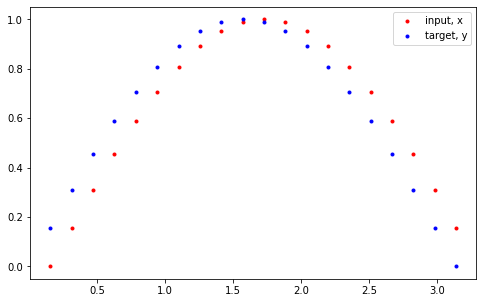

In [97]:
plt.figure(figsize=(8,5))

# how many time steps/data pts are in one batch of data
seq_length = 20

# generate evenly spaced data pts
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] # all but the last piece of data
y = data[1:] # all but the first

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [99]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden


In [100]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate evenly spaced, test data pts
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

Input size:  torch.Size([1, 20, 1])
Output size:  torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


In [101]:
data.shape

(20, 1)

In [102]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [106]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [107]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        print (data.shape)
        data.resize((seq_length + 1, 1)) # input_size=1
        print(data.shape)
        print(seq_length)

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn

(21,)
(21, 1)
20
Loss:  0.2060241401195526


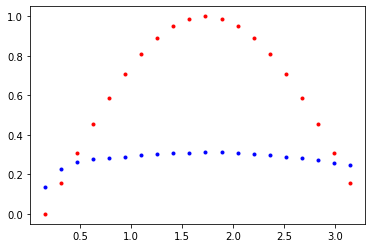

(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
Loss:  0.011898542754352093


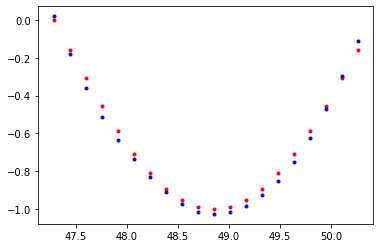

(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
Loss:  0.004683796316385269


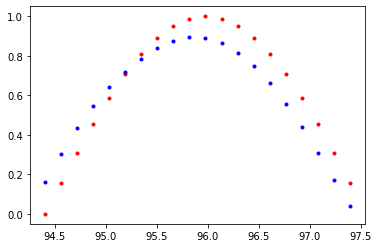

(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
Loss:  0.010535793378949165


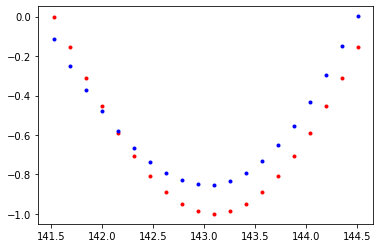

(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
Loss:  0.0004911283031105995


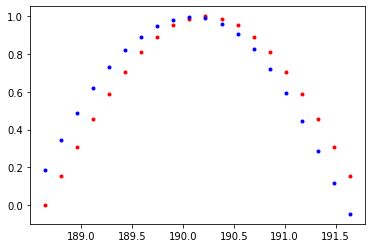

(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20
(21,)
(21, 1)
20


In [108]:
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)